In [1]:
from google.colab import drive
drive.mount('/content/pinn-main')

Drive already mounted at /content/pinn-main; to attempt to forcibly remount, call drive.mount("/content/pinn-main", force_remount=True).


In [2]:
cd /content/pinn-main/MyDrive/pinns-main/modulo

/content/pinn-main/MyDrive/pinns-main/modulo


In [3]:
import argparse
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

In [4]:
# !pip install wandb -qU
# !pip install ml_collections
import modulus
import data_generator as dg
import default
import wandb

In [8]:
torch.manual_seed(44)
np.random.seed(44)
torch.cuda.manual_seed(44)

      utils.py

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def ac_equation(u, tx):
    u_tx = torch.autograd.grad(u, tx, torch.ones_like(u), create_graph= True)[0]
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    u_xx = torch.autograd.grad(u_x, tx, torch.ones_like(u_x), create_graph= True)[0][:, 1:2]
    e = u_t -0.0001*u_xx + 5*u**3 - 5*u
    return e

def resplot(x, t, t_data, x_data, Exact, u_pred):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(x, Exact[:,0],'-')
    plt.plot(x, u_pred[:,0],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("Initial condition ($t=0$)")

    plt.subplot(2, 2, 2)
    t_step = int(0.25*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.25$")

    plt.subplot(2, 2, 3)
    t_step = int(0.5*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.5$")

    plt.subplot(2, 2, 4)
    t_step = int(0.99*len(t))
    plt.plot(x, Exact[:,t_step],'-')
    plt.plot(x, u_pred[:,t_step],'--')
    plt.legend(['Reference', 'Prediction'])
    plt.title("$t=0.99$")
    plt.show()
    plt.close()


In [ ]:

class TrainClass:
    def __init__(self, cfg, wandbFlag=False):
        # Конфигурация
        self.num_t = cfg.num_t
        self.num_x = cfg.num_x
        self.num_epochs = cfg.epochs
        self.num_hidden_layers = 4
        self.num_nodes = cfg.hidden_count
        self.learning_rate = cfg.lr
        self.data_path = cfg.data_path
        self.wandbFlag = wandbFlag

        #Подключение отслеживания с помощью wandb
        if self.wandbFlag:
          self.__wandbConnect(cfg)

        # Устройство
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Operation mode: ", self.device)

        # Данные
        self.__createData()
        # Модель
        self.model = modulus.pinn(cfg).to(self.device)

        # Оптимизатор
        self.optimizer = torch.optim.Adam(self.model.parameters(), betas=(0.999, 0.999), lr=self.learning_rate)

        # Логирование
        self.loss_history = []
        self.l2_history = []
        self.best_loss = float('inf')
        self.best_epoch = 0

    '''
    Подключается к wandb для отслеживания процесса обучения
    '''
    def __wandbConnect(self, cfg):
        wandb.login()
        wandb.init(
            project=cfg.project,
            name=cfg.name,
            config={
            "epochs": cfg.epochs,
            })
    '''
    Генерирует данные:
      variables - выборка, содержищие граничные и начальные условия
      variables_f - вся выборка
      u_data - содержит решение для выборки variables
    '''
    def __createData(self):
        self.t_data, self.x_data, self.u_data, self.t_data_f, self.x_data_f = dg.ac_generator(self.num_t, self.num_x)
        self.variables = torch.FloatTensor(np.concatenate((self.t_data, self.x_data), axis=1)).to(self.device)
        self.variables_f = torch.FloatTensor(np.concatenate((self.t_data_f, self.x_data_f), axis=1)).to(self.device)
        self.variables_f.requires_grad = True
        self.u_data = torch.FloatTensor(self.u_data).to(self.device)

    '''
    Считает L2 потерю относительно верного решения, находящимся по пути cfg.data_path
    '''
    def __calculate_l2_error(self):
        t = np.linspace(0, 1, 201).reshape(-1, 1)
        x = np.linspace(-1, 1, 513)[:-1].reshape(-1, 1)
        T = t.shape[0]
        N = x.shape[0]
        T_star = np.tile(t, (1, N)).T
        X_star = np.tile(x, (1, T))
        t_test = T_star.flatten()[:, None]
        x_test = X_star.flatten()[:, None]

        test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), axis=1)).to(self.device)
        with torch.no_grad():
            u_pred = self.model(test_variables)
        u_pred = u_pred.cpu().numpy().reshape(N, T)

        # Сравнение с эталоном
        data = scipy.io.loadmat(self.data_path)
        exact_solution = np.real(data['uu'])
        error = np.linalg.norm(u_pred - exact_solution, 2) / np.linalg.norm(exact_solution, 2)
        return error


    
    '''
    Выводит график функции потерь, а также эпоху с наименьшей величиной потерь
    '''
    def printLossGraph(self):
        print(f"[Best][Epoch: {self.best_epoch}] Train loss: {self.best_loss}")
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.l2_history)
        plt.show()

    '''
    Выводит график вычисленного уравнения
    '''
    def printEval(self):
      #Загружаем лучшие веса
      self.model.load_state_dict(torch.load('./ac_1d.pth'))

      #Подготовка данных и вывод L2
      t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
      x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
      T = t.shape[0]
      N = x.shape[0]
      T_star = np.tile(t, (1, N)).T  # N x T
      X_star = np.tile(x, (1, T))  # N x T
      t_test = T_star.flatten()[:, None]
      x_test = X_star.flatten()[:, None]

      test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(self.device)
      with torch.no_grad():
          u_pred = self.model(test_variables)
      u_pred = u_pred.cpu().numpy().reshape(N,T)

      data = scipy.io.loadmat(self.data_path)
      Exact = np.real(data['uu'])
      err = u_pred-Exact

      err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)
      print(f"L2 Relative Error: {err}")

      #Рисуем графики
      resplot(x, t, self.t_data, self.x_data, Exact, u_pred)

      plt.figure(figsize=(10, 5))
      plt.imshow(u_pred, interpolation='nearest', cmap='jet',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
      plt.clim(-1, 1)
      plt.ylim(-1,1)
      plt.xlim(0,1)
      plt.scatter(self.t_data, self.x_data)
      plt.xlabel('t')
      plt.ylabel('x')
      plt.title('u(t,x)')
      plt.show()

    '''
    Функция тренировки нейросети
    '''
    def train(self):
        for epoch in tqdm(range(self.num_epochs)):
            self.optimizer.zero_grad()

            # Предсказания
            u_pred = self.model(self.variables)
            u_pred_f = self.model(self.variables_f)

            # Вычисление функции потерь
            loss_f = torch.mean(ac_equation(u_pred_f, self.variables_f) ** 2)
            loss_u = torch.mean((u_pred - self.u_data) ** 2)
            loss = loss_f + loss_u

            # Обновление весов
            loss.backward()
            self.optimizer.step()

            current_loss = loss.item()
            self.loss_history.append(current_loss)
            l2_error = self.__calculate_l2_error()
            self.l2_history.append(l2_error)

            # Сохранение лучшей модели
            if current_loss < self.best_loss:
                self.best_loss = current_loss
                self.best_epoch = epoch
                torch.save(self.model.state_dict(), f'./ac_1d.pth')

            # Логирование
            if epoch:
                print(f"Epoch {epoch}, Train loss: {current_loss}, L2: {l2_error}")
                
                if self.wandbFlag:
                  wandb.log({"epoche": epoch, "loss": current_loss})
                  wandb.log({"epoche": epoch, "L2": l2_error})

            # if epoch % 500 == 0:
            #     l2_error = self.__calculate_l2_error()
            #     if self.wandbFlag:
            #       wandb.log({"epoche": epoch, "L2": l2_error})
            #     print(f"L2 Relative Error: {l2_error}")
        self.printLossGraph()


<class 'ml_collections.config_dict.config_dict.ConfigDict'>
Operation mode:  cpu
2


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
 10%|█         | 1/10 [00:05<00:45,  5.10s/it]

L2 Relative Error: 1.0401084765368944


 20%|██        | 2/10 [00:07<00:29,  3.65s/it]

Epoch 1, Train loss: 0.8416198492050171


 30%|███       | 3/10 [00:09<00:20,  2.97s/it]

Epoch 2, Train loss: 0.952528715133667


 40%|████      | 4/10 [00:12<00:17,  2.92s/it]

Epoch 3, Train loss: 0.4340556859970093


 50%|█████     | 5/10 [00:14<00:12,  2.41s/it]

Epoch 4, Train loss: 0.6094091534614563


 60%|██████    | 6/10 [00:16<00:09,  2.27s/it]

Epoch 5, Train loss: 0.6154038310050964


 70%|███████   | 7/10 [00:18<00:06,  2.23s/it]

Epoch 6, Train loss: 0.5486170053482056


 80%|████████  | 8/10 [00:19<00:03,  1.87s/it]

Epoch 7, Train loss: 0.6083793640136719


 90%|█████████ | 9/10 [00:20<00:01,  1.64s/it]

Epoch 8, Train loss: 0.6357349157333374


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]

Epoch 9, Train loss: 0.5454375743865967
[Best][Epoch: 3] Train loss: 0.4340556859970093


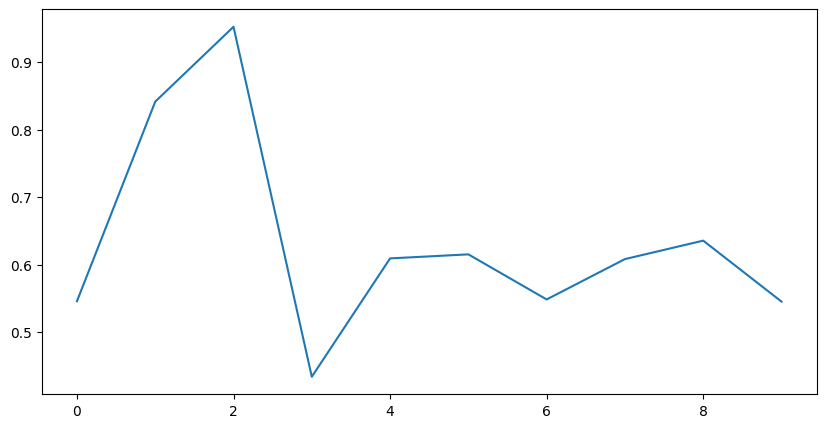

<ipython-input-11-7fa8fef92a9e>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('./ac_1d.pth'))


L2 Relative Error: 1.0431985201721488


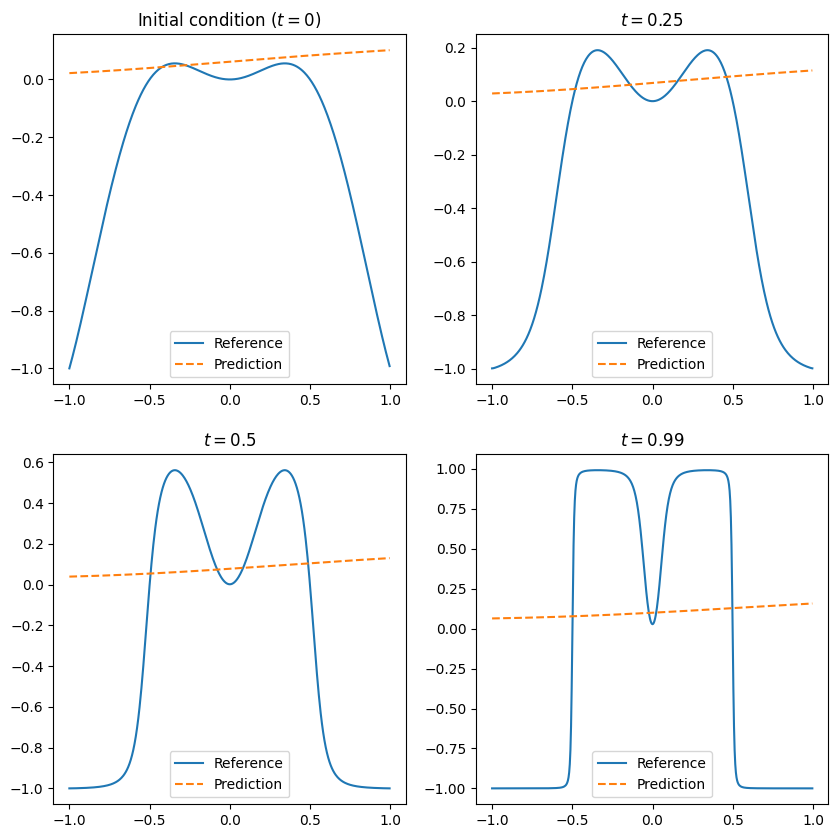

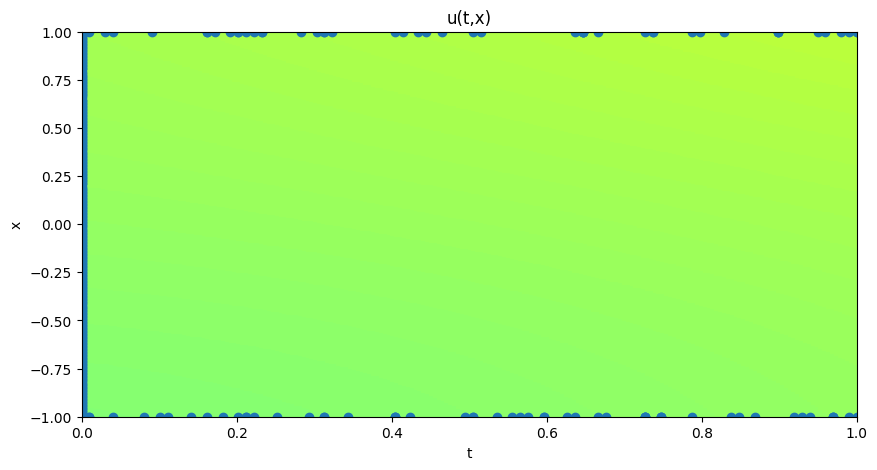

In [12]:
a = TrainClass(default.get_config())
a.train()
# a.printLossGraph()
a.printEval()
# a.train()